# Example of `pydarm` usage

**Caveat 1: `pydarm` source code is not publicly available because it is still under active development. While most key features have been implemented, not everything has been tested completely for robustness in a wide range of possible DARM loop configurations/settings.**

**Caveat 2: I'm demonstrating the library not a command line interface in this notebook. Future development of `pyDARM` will enable command line interface for standard operations.**

## Prerequisites
We have installed `pyDARM` into a `conda` environment at CIT for this example. To do this, via the terminal on jupyter.ligo.caltech.edu, we created a new `conda` environment and set it up with everything that we needed:
```bash
conda env create --name pydarm-testing
conda activate pydarm-testing
conda install -c conda-forge pydarm
```
Note: for me, I needed to follow the steps on the terminal output to initialize conda bash and then restart the terminal

```bash
conda install -c conda-forge ipykernel
python -m ipykernel install --user --name pydarm-testing --display-name "py3.9 pydarm-testing"
```

Then in an ipython notebook, I can select the `py3.9 pydarm-testing` kernel in order to proceed further.

## Tutorial
**Caveat 3: These demos should work in the future as well, perhaps with small modifications due to API changes.**

**Caveat 4: this notebook currently starts from having several key "building block" steps already carried out: 1) the photon calibrator has been calibrated (EPICS records updated); 2) the analog electronics chassis have been measured and compensated with digital filters (to the degree possible) and exported to `.mat` files; 3) suspension dynamics have been updated/uploaded to PCAL EPICS/exported to `.mat` file.**

First setting up modules for import and showing plots in the ipython notebook. Note here that we are importing `pyDARM` as a module

In [71]:
%matplotlib inline

import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
import corner
import pydarm

The new version of `pydarm` will eventually be able to do many different things in different ways. "Standard procedures" may eventually be mostly available via the command line interface, with more detailed interaction available via the library interface. 

This tutorial shows how to generate transfer functions of different components of the DARM control loop or put everything together to get a total response function. We also demonstrate the use of `pyDARM` to process measurement data directly from DTT files (no ASCII exports anymore) and perform MCMC analysis of the measurement data. Soon, `pyDARM` will process multiple measurements for "stacking" and GPR analysis to produce data products for uncertainty estimation.

`pyDARM` needs some input parameters in order to build transfer functions. These input parameters are taken as `key,value` pairs under sections of a configuration string or file. An example configuration file is in the project repository under `example_model_files/H1_20190416.ini`, but we can also show what is needed by strings.

To be explicit in this tutorial, I will show the strings of the parameters used. These strings could instead be saved in a configuration file and the configuration file string passed as the argument.

Some external files are passed as parameters to create the DARM model. One could specify the full path to each file as needed, or the files can be hosted in a particular location visible to the file system and one merely needs to give the path with respect to the environment variable `CAL_DATA_ROOT`. Here we specify and make it visible to this notebook:

In [72]:
import os
os.environ['CAL_DATA_ROOT'] = '/home/cal/svncommon/aligocalibration/trunk/'

Transfer functions (complex-values) are calculated on a per-frequency basis. Our frequency region of concern is over the sensitive band of the detector 10 Hz - a few kHz, so we typically want to investigate 5 Hz to 5 kHz

In [73]:
frequencies = np.logspace(np.log10(1), np.log10(5000), 100)

## Example model configuration

Below we use a text string to define a model configuration file. This could instead be written to a separate `.ini` configuration file. Objects and methods within `pyDARM` will automatically detect whether this variable is a configuration string or path to a file.

One can see below there are sections delineated with square brackets as `[section]`. Within that section are `key,value` pairs separated with `=`. Comments can be on their own line or at the end of lines and are marked with `#`. Every configuration file/string must contain `[metadata]` and `[interferometer]` sections. Other sections are optional, though depending on what you are doing are required by particular class or method (see further below).

Certain values are optional or permitted to be empty. Mostly these are associated with compensation of the actuation analog electronics. This may evolve somewhat in the near term as this is more fully fleshed out in the modeling.

In [74]:
model_string = '''
[metadata]
run = O3
model_date = 2021-04-17

# GPS times for which the model is valid
start = 1302710418
end   = 1307116818

[interferometer]
name         = H1

[sensing]
# Parameters directly associated with sensing function
coupled_cavity_optical_gain   = 3.4e6
coupled_cavity_pole_frequency = 450.7
detuned_spring_frequency      = 4.3
detuned_spring_Q              = 10
sensing_sign                  = 1
is_pro_spring                 = False

# Interferometer arm lengths
x_arm_length = 3994.4704
y_arm_length = 3994.4692

# Name of OMC DCPD paths
omc_path_names = A, B

# Anti-aliasing filter parameters
anti_aliasing_rate_string = 16k
anti_aliasing_method      = biquad
analog_anti_aliasing_file = Common/pyDARM/matlab_scripts/H1aa.mat, Common/pyDARM/matlab_scripts/H1aa.mat

# OMC pole frequencies
omc_meas_z_trans_amplifier   = 
omc_meas_p_trans_amplifier   = 13.7e3, 17.8e3: 13.7e3, 17.8e3
whitening_mode_names = h1o3, h1o3
omc_meas_z_whitening_h1o3 = 
omc_meas_p_whitening_h1o3 = 17.873e3, 98.2771e3, 86.2587e3: 18.046e3, 98.4137e3, 86.7888e3

super_high_frequency_poles_apparent_delay = 0, 0

# Single pole approximation has too much delay for true length response,
# so here there is an advance (the minus sign on a delay) added. See G1501316
single_pole_approximation_delay_correction = -12e-6

adc_gain = 1, 1

# This is the compensation filter bank, modules in use, and gain
# Optional
# The gain values are not used if the filter bank name is not given
omc_compensation_filter_file = Common/H1CalFilterArchive/h1omc/H1OMC_1239468752.txt
omc_compensation_filter_bank = OMC_DCPD_A, OMC_DCPD_B
omc_compensation_filter_modules_in_use =
omc_compensation_filter_gain = 1, 1

# OMC path gain ratio
# Gain ratio is the product of:
# OMC BS ratio
# PD gain ratio
# Transimpedence amplifier gain ratio
# Whitening chassis gain ratio
# Analog AA gain ratio
# ADC gain ratio
# (If not set above in the filter banks and gain) the rough A/ct (or mA/ct) ratio
# Numerator is the path in question, denominator is the reference path
# which is usually the "A" path
gain_ratio = 1, 1  # only the reference will often be 1, and we desire the others to be 1 as well (often not exactly)

# The digital gain set in the front end balance matrix
balance_matrix = 1, 1

[digital]
digital_filter_file           = Common/H1CalFilterArchive/h1omc/H1OMC_1239468752.txt
digital_filter_bank           = LSC_DARM1, LSC_DARM2
digital_filter_modules_in_use = 1,2,3,4,7,9,10: 3,4,5,6,7
digital_filter_gain           = 400,1

[actuation]
# Fill in DARM output matrix values [EX,EY,IX,IY]
darm_output_matrix = 1.0, -1.0, 0.0, 0.0
# Fill in OFF or ON for a 1x4 array [MO,L1,L2,L3] for X and Y arms
darm_feedback_x    = OFF, ON, ON, ON
darm_feedback_y    = OFF, OFF, OFF, OFF

#################
#    x - arm    #
#################
[actuation_x_arm]
darm_feedback_sign = -1  # This should not be changed
# UIM = 1.634     ==> 7.67e-08 (N/ct)
# PUM = 0.02947   ==> 6.036e-10 (N/ct)
# TST = 4.427e-11 ==> 4.727e-12 (N/ct)
uim_NpA       = 1.62958
pum_NpA       = 0.02956
tst_NpV2      = 4.45007e-11
linearization = OFF
actuation_esd_bias_voltage = -9.3

# actuation filter file
sus_filter_file = Common/H1CalFilterArchive/h1susetmx/H1SUSETMX_1256232808.txt

# TST interferometer sensing and control
tst_isc_inf_bank    = ETMX_L3_ISCINF_L
tst_isc_inf_modules =
tst_isc_inf_gain    = 1.0

# TST lock settings
tst_lock_bank       = ETMX_L3_LOCK_L
tst_lock_modules    = 5,8,9,10
tst_lock_gain       = 1.0

# TST drive align
tst_drive_align_bank     = ETMX_L3_DRIVEALIGN_L2L
tst_drive_align_modules  = 4,5
tst_drive_align_gain     = -35.7

# PUM lock settings
pum_lock_bank    = ETMX_L2_LOCK_L
pum_lock_modules = 7
pum_lock_gain    = 23.0

# PUM drive align settings
pum_drive_align_bank   = ETMX_L2_DRIVEALIGN_L2L
pum_drive_align_modules = 6,7
pum_drive_align_gain    = 1.0
# L1 needs -1 here, because of poor OSEM convention V
pum_coil_outf_signflip  = 1

# UIM lock settings
uim_lock_bank    = ETMX_L1_LOCK_L
uim_lock_modules = 2,10
uim_lock_gain    = 1.06

# UIM dirive align settings
uim_drive_align_bank    = ETMX_L1_DRIVEALIGN_L2L
uim_drive_align_modules =
uim_drive_align_gain    = 1.0

# suspension file contains the force to length transfer function
suspension_file = Common/pyDARM/matlab_scripts/20200107_H1_EX_O3_susdata.mat

# Driver parameters and setup. Updated 2019-03-04, LHO aLOG 44469
tst_driver_meas_Z_UL = 129.7e3
tst_driver_meas_Z_LL = 90.74e3
tst_driver_meas_Z_UR = 93.52e3
tst_driver_meas_Z_LR = 131.5e3
tst_driver_meas_P_UL = 3.213e3, 31.5e3
tst_driver_meas_P_LL = 3.177e3, 26.7e3
tst_driver_meas_P_UR = 3.279e3, 26.6e3
tst_driver_meas_P_LR = 3.238e3, 31.6e3
# This is the compensation filter FOTON export data
# Only add these files if you also put the low frequency poles and zeros
# in the above measured zeros and poles values, otherwise below can be blank
# The same is true if you add the zeros and poles above, you need to add the
# exported FOTON values below
tst_compensation_filter_bank =
tst_compensation_filter_modules_in_use =
tst_compensation_filter_gain =

pum_compensation_filter_bank =
pum_compensation_filter_modules_in_use =
pum_compensation_filter_gain =

uim_compensation_filter_bank =
uim_compensation_filter_modules_in_use =
uim_compensation_filter_gain =

# Dead reckoned from circuit schematic
tst_driver_DC_gain_VpV_HV = 40
tst_driver_DC_gain_VpV_LV = 1.881
pum_driver_DC_trans_ApV = 2.6847e-4
uim_driver_DC_trans_ApV = 6.1535e-4

# anti imaging filter file settings
anti_imaging_rate_string = 16k
anti_imaging_method      = biquad
analog_anti_imaging_file = Common/pyDARM/matlab_scripts/H1aa.mat
dac_gain = 7.62939453125e-05

unknown_actuation_delay = 15e-6
uim_delay = 
pum_delay = 
tst_delay = 

[pcal]
pcal_dewhiten               = 1.0, 1.0

# Used for measurements like swept sine or broadband transfer functions
# x-arm ==> 1, y-arm ==> -1
ref_pcal_2_darm_act_sign    = -1.0

# Pcal Anti-aliasing filter parameters
anti_aliasing_rate_string = 16k
anti_aliasing_method      = biquad
analog_anti_aliasing_file = Common/pyDARM/matlab_scripts/H1aa.mat

[calcs]
# GDS Compensation for Bad Foton Filter Approximation for High Frequency Roll-Off of Calibration
foton_invsensing_tf = ../test/2019-04-04_H1CALCS_InverseSensingFunction_Foton_SRCD-2N_Gain_tf.txt

xarm_uim_coiloutf =
xarm_pum_coiloutf =
xarm_tst_coiloutf =
yarm_uim_coiloutf =
yarm_pum_coiloutf =
yarm_tst_coiloutf =

# Here we can put some filter exports for what CAL-CS is doing
# Need to export transfer functions of applied filters (multiple)
xarm_uim_analog = ../test/H1CALCS_ETMX_L1_ANALOG.txt
xarm_pum_analog = ../test/H1CALCS_ETMX_L2_ANALOG.txt
xarm_tst_analog = ../test/H1CALCS_ETMX_L3_ANALOG.txt
yarm_uim_analog =
yarm_pum_analog =
yarm_tst_analog =

xarm_output_matrix = 0.0, -1.0, -1.0, -1.0
yarm_output_matrix = 0.0, 0.0, 0.0, 0.0

foton_delay_filter_tf = ../test/H1CALCS_8_CLK_DELAY.txt

# This is the CAL-DELTAL_EXTERNAL whitening transfer function export
foton_deltal_whitening_tf = ../test/H1CALCS_DELTAL_EXTERNAL_WHITENING_tf.txt

[gds]
# Here we can put some GDS stuff
# Right now this doesn't do anything
pum_driver_gds_compensation =
tst_driver_gds_compensation =
'''

### Sensing function demo

**Example:** Plot the sensing function.

Let's make a sensing function transfer function for frequencies between 5 Hz and 5000 Hz and plot the results. Note here that we're making an instance of a `SensingModel` object, which defines only the sensing part of the DARM loop. We will see later how to make a complete model.

**Note:** we are making use of the `pyDARM` plotting methods to produce "standardized" outputs. This also greatly saves on code overhead, since we don't have to put so many similar lines of code into scripts.

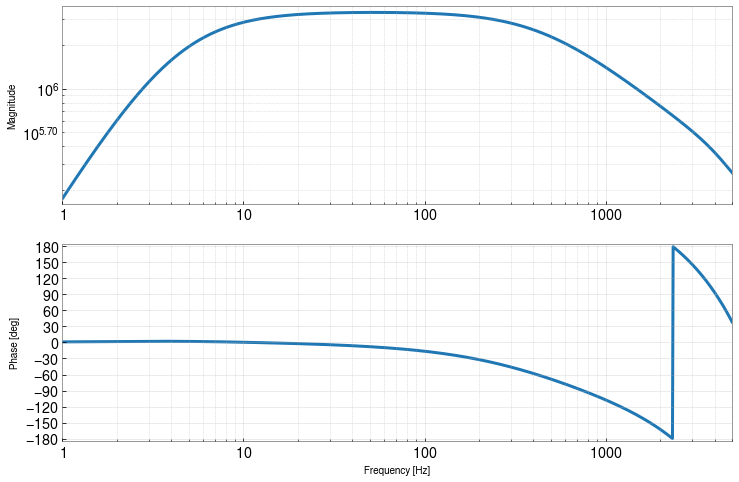

In [75]:
sensing = pydarm.sensing.SensingModel(model_string)
h = pydarm.plot.plot(frequencies, sensing.compute_sensing, freq_min=1, freq_max=5000, show=True)

Note that we could also use a configuration file to accomplish a similar result. We would be able to use
```
sensing = pydarm.sensing.SensingModel(<filename>)
```

### Actuation function demo

The actuation function is more complex because of the two arms and many components to the quadruple suspension system. Thus, many more parameters are required to be defined by the configuration parameters (see above parameter file).

**Example:** Plot the actuation function.
Just as easy as the sensing function above, and note again that we're initializing a `DARMActuationModel` object

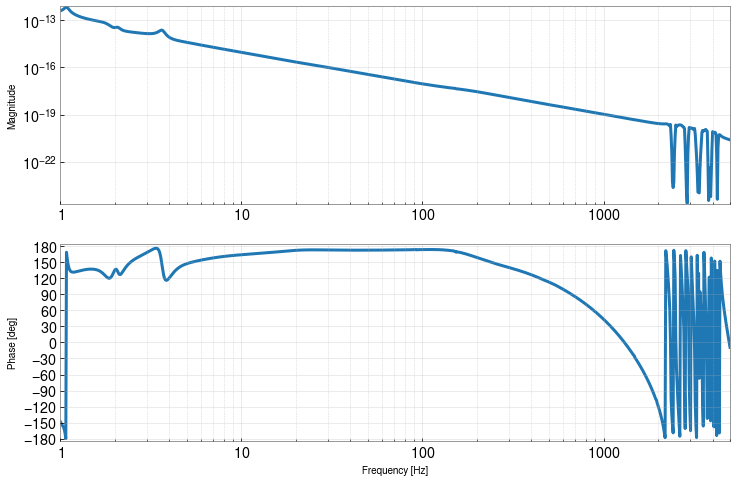

In [76]:
actuation = pydarm.actuation.DARMActuationModel(model_string)
h = pydarm.plot.plot(frequencies, actuation.compute_actuation, freq_min=1, freq_max=5000, show=True)

### Digital filtering demo
The DARM loop digital filters are simply mathematical functions in a `FOTON` filter file. We can plot those values quite easily by specifying the file, the filter bank names, filter modules activated (turned on), and the gain for each of the filter banks. 

**Example:** Plot the digital filter.

In this example below, a `DigitalModel` object is initialized.

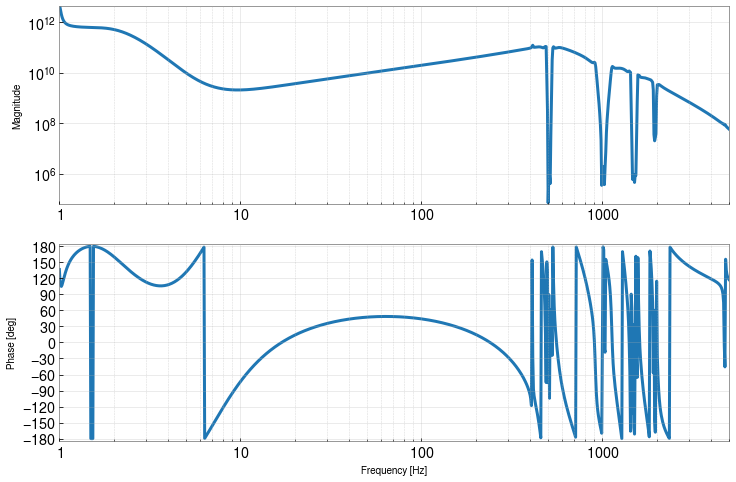

In [77]:
digital = pydarm.darm.DigitalModel(model_string)
h = pydarm.plot.plot(frequencies, digital.compute_response, freq_min=1, freq_max=5000, show=True)

### DARM loop demo
Putting the three pieces together is also straightforward. 

**Example:** Plot the DARM open loop gain.

Here, a `DARMModel` object is initialized that contains all three pieces: sensing, actuation, and digital filtering.

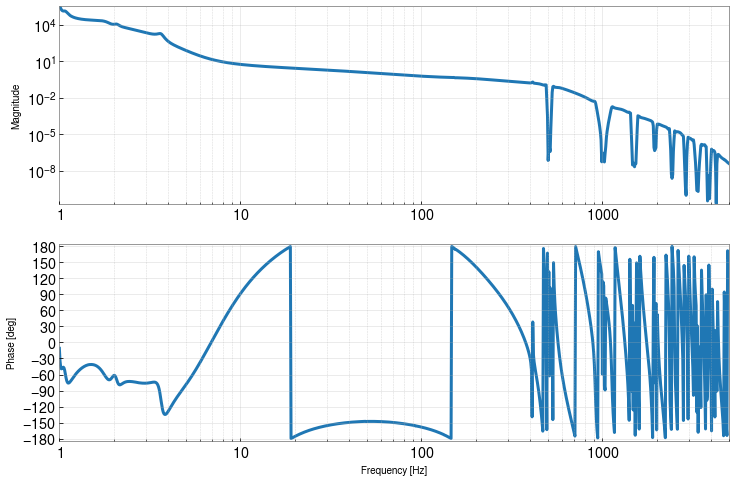

In [78]:
darm = pydarm.darm.DARMModel(model_string)
h = pydarm.plot.plot(frequencies, darm.compute_darm_olg, freq_min=1, freq_max=5000, show=True)

If we want to know the unity gain frequency, there is a special plot function to do this:

In [79]:
f_ugf, phi_ugf = pydarm.plot.get_ugf(frequencies, darm.compute_darm_olg(frequencies))
print(f'{f_ugf} Hz, {phi_ugf} degrees margin')

58.0 Hz, -148.0 degrees margin


**Example:** Plot the response function

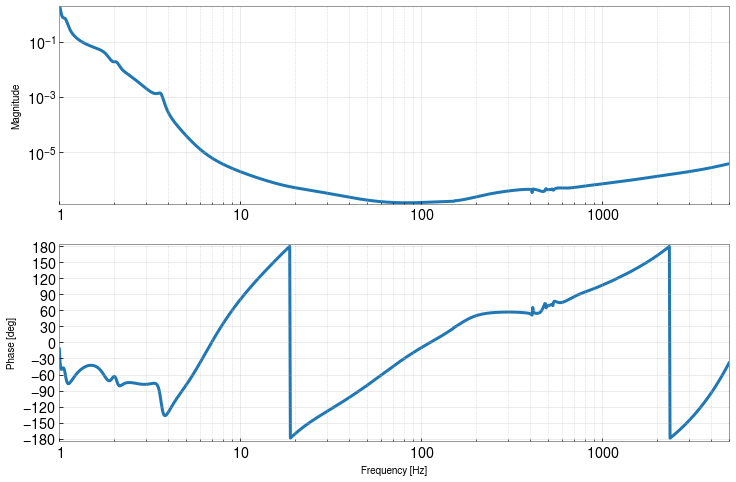

In [80]:
h = pydarm.plot.plot(frequencies, darm.compute_response_function, freq_min=1, freq_max=5000, show=True)

**Example:** Plot contribution of individual components to the response function.

Here we show a more sophisticated query of the underlying transfer functions. These can be obtained via method calls to the various DARM loop components.

Note that `darm` is a `DARMModel` object, `actuation` (a `DARMActuationModel` object) is a property of `DARMModel`, `xarm` (an `ActuationModel` object) is a property of `DARMActuationModel` objects, and `compute_actuation_single_stage` is a method of `ActuationModel` objects.

We can also obtain "standard" transfer functions from the `DARMModel` object (`sensing` and `actuation` are properties of `DARMModel` objects).

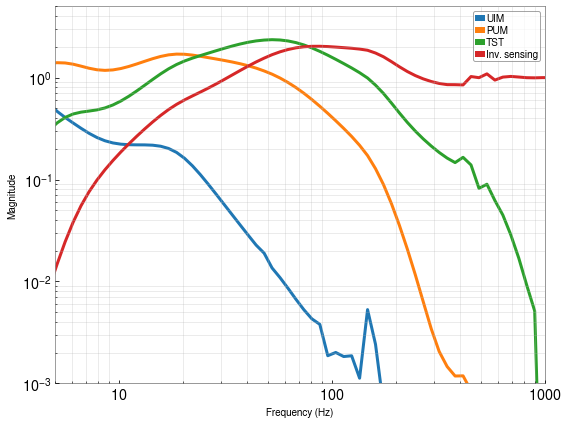

In [81]:
tst_response = darm.actuation.xarm.compute_actuation_single_stage(frequencies, stage='TST')
pum_response = darm.actuation.xarm.compute_actuation_single_stage(frequencies, stage='PUM')
uim_response = darm.actuation.xarm.compute_actuation_single_stage(frequencies, stage='UIM')
sensing_transfer_function = darm.sensing.compute_sensing(frequencies)
digital_transfer_function = darm.digital.compute_response(frequencies)
response = darm.compute_response_function(frequencies)
plt.figure(figsize=[8,6])
plt.plot(frequencies, np.abs((uim_response*digital_transfer_function)/response), label='UIM')
plt.plot(frequencies, np.abs((pum_response*digital_transfer_function)/response), label='PUM')
plt.plot(frequencies, np.abs((tst_response*digital_transfer_function)/response), label='TST')
plt.plot(frequencies, np.abs((1/sensing_transfer_function)/response), label='Inv. sensing')
plt.xscale('log')
plt.yscale('log')
plt.xlim(5,1000)
plt.ylim(1e-3,5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(which='both')
plt.legend()
plt.tight_layout()
plt.show()

## Example usage for MCMC

**Important note: currently the MCMC development is in a branch/merge request, so it is not yet part of the production package of `pyDARM`**

### Sensing function measurements

Jeff Kissel and Jenne Driggers took some measurements April 17 2021; here we will give an example for how the `pyDARM` package can be used to process the data through the MCMC.

To actually run the MCMC, we have to provide two `Measurement` objects (essentially pointers to the .xml files with methods that know how to interact with the DTT .xml files), the channel names for transfer functions, and coherence thresholds. This is a total of 6 items needed to process a measurement.

It's a simple call to run the MCMC as a method for the `ProcessSensingMeasurement` object: `run_mcmc`

In [82]:
meas_obj_1 = pydarm.measurement.Measurement(
    '/home/cal/svncommon/aligocalibration/trunk/Runs/O3/H1/Measurements/FullIFOSensingTFs/2021-04-17_H1_DARM_OLGTF_LF_SS_5to1100Hz_15min.xml')
meas_obj_2 = pydarm.measurement.Measurement(
    '/home/cal/svncommon/aligocalibration/trunk/Runs/O3/H1/Measurements/FullIFOSensingTFs/2021-04-17_H1_PCAL2DARMTF_LF_SS_5t1100Hz_10min.xml')
meas = pydarm.measurement.ProcessSensingMeasurement(model_string, meas_obj_1, meas_obj_2,
                                                    ('H1:LSC-DARM1_IN2', 'H1:LSC-DARM1_EXC'),
                                                    ('H1:CAL-PCALY_RX_PD_OUT_DQ', 'H1:LSC-DARM_IN1_DQ'),
                                                    meas1_cohThresh=0.9, meas2_cohThresh=0.9)
chain = meas.run_mcmc(fmin=30, fmax=5000, save_to_file='./example_sensing.json', burn_in_steps=100, steps=100)
MAP = np.median(chain, axis=0)
print(MAP)

100%|██████████| 100/100 [00:10<00:00,  9.15it/s]


[8.99651469 9.11181469 8.95555197 8.76165463 8.9515949 ]
[3.43929865e+06 4.50565641e+02 4.30953443e+00 3.23062106e-02
 6.57319811e+00]


We can use the `corner` package to make a corner plot of the sensing MCMC posteriors

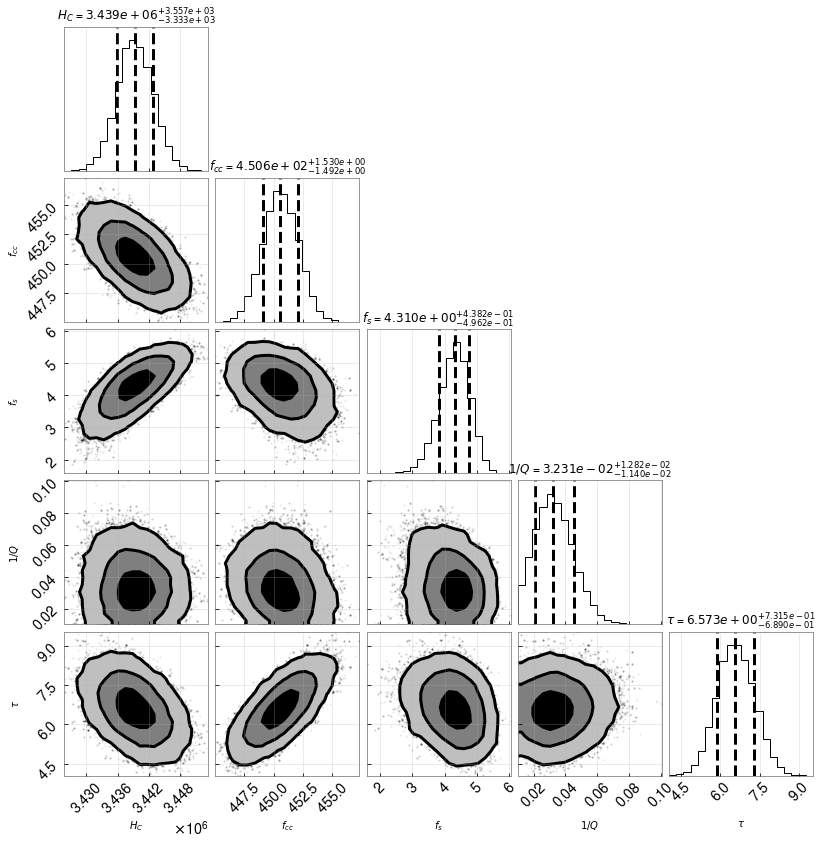

In [83]:
figure = corner.corner(chain, labels=[r"$H_C$", r"$f_{cc}$", r"$f_s$", r"$1/Q$", r"$\tau$"], 
                       quantiles=[0.16, 0.5, 0.84], levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                       show_titles=True, title_kwargs={"fontsize": 12}, smooth=0.5, title_fmt='.3e', 
                       plot_datapoints=True, plot_density=False, fill_contours=True, plot_contours=True,
                       use_math_text=True)

Now I update the sensing model parameters. TODO: Perhaps this could be done automatically in the future

In [84]:
darm.sensing.coupled_cavity_optical_gain = MAP[0]
darm.sensing.coupled_cavity_pole_frequency = MAP[1]
darm.sensing.detuned_spring_frequency = MAP[2]
darm.sensing.detuned_spring_q = 1/MAP[3]

Maybe one wants to plot the processed transfer function data and compare it against the model. We can do that too with a few lines calling methods from the `Measurement` class and the `DARMModel` class. This is so we can compare the two on plots.

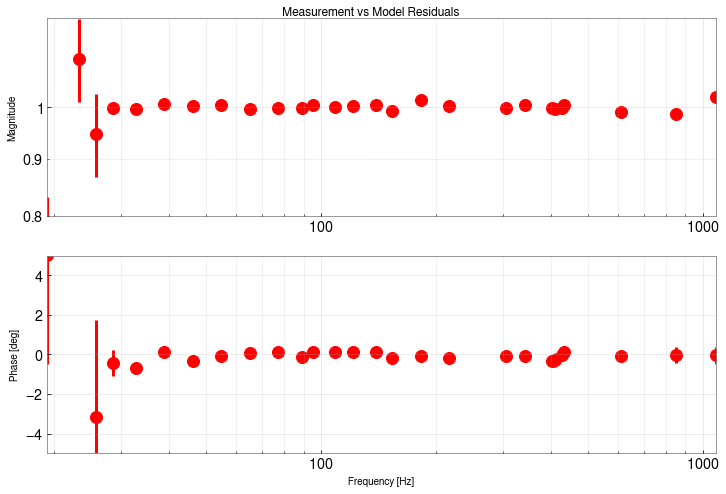

In [85]:
freq, tf, unc = meas.get_processed_measurement_response()

# This includes the residual delay found from the MCMC (currently not in the model config file)
model_resp = (darm.sensing.coupled_cavity_optical_gain * 
              signal.freqresp(darm.sensing.optical_response(darm.sensing.coupled_cavity_pole_frequency,
                                                            darm.sensing.detuned_spring_frequency,
                                                            darm.sensing.detuned_spring_q,
                                                            darm.sensing.is_pro_spring), 2*np.pi*frequencies)[1] *
              np.exp(-2*np.pi*1j*MAP[4]*frequencies*1e-6))

h = pydarm.plot.residuals(frequencies, model_resp, freq, tf, unc, show=True)

### Actuation measurements

We can run the MCMC method to obtain posterior estimates of the actuator parameters as well. Here we demonstrate from the recent measurements on the TST, PUM, and UIM

First we show the few steps needed to make an MCMC:

In [86]:
meas_obj_L3_exc = pydarm.measurement.Measurement(
    '/home/cal/svncommon/aligocalibration/trunk/Runs/O3/H1/Measurements/FullIFOActuationTFs/2021-04-16_H1SUSETMX_L3_iEXC2DARM_12min.xml')
meas_obj_L3_pcal = pydarm.measurement.Measurement(
    '/home/cal/svncommon/aligocalibration/trunk/Runs/O3/H1/Measurements/FullIFOActuationTFs/2021-04-16_H1SUSETMX_L3_PCAL2DARM_6min.xml')
tst_meas = pydarm.measurement.ProcessActuationMeasurement(model_string, 'actuation_x_arm', meas_obj_L3_exc, meas_obj_L3_pcal,
                                                    ('H1:SUS-ETMX_L3_CAL_EXC', 'H1:LSC-DARM_IN1_DQ'),
                                                    ('H1:CAL-PCALY_RX_PD_OUT_DQ', 'H1:LSC-DARM_IN1_DQ'),
                                                    meas1_cohThresh=0.9, meas2_cohThresh=0.9)
chain = tst_meas.run_mcmc(fmin=30, fmax=800, burn_in_steps=100, steps=100)
MAP_tst = np.median(chain, axis=0)
print(MAP_tst)

100%|██████████| 100/100 [00:07<00:00, 13.30it/s]


[8.08178354 8.18457068]
[ 4.66913829e-11 -6.61579439e+00]


Next we show a comparison of measurement to model:

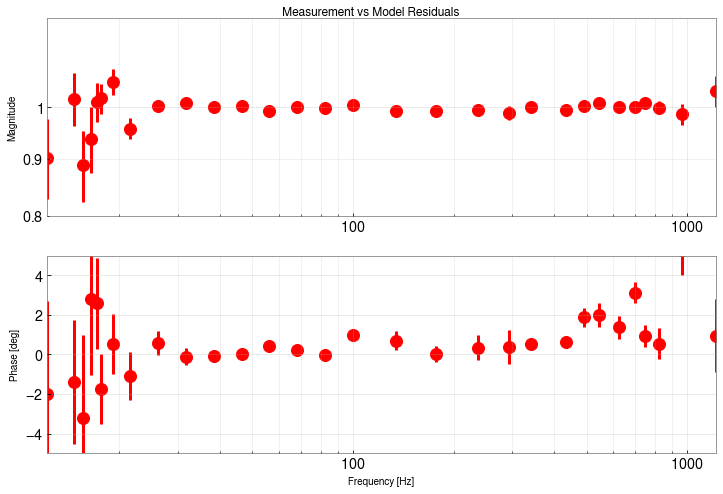

In [87]:
freq, tf, unc = tst_meas.get_processed_measurement_response()
tst = MAP_tst[0] * np.ones(len(frequencies))

h = pydarm.plot.residuals(frequencies, tst, freq, tf, unc, show=True)

Same for PUM:

In [88]:
meas_obj_L2_exc = pydarm.measurement.Measurement(
    '/home/cal/svncommon/aligocalibration/trunk/Runs/O3/H1/Measurements/FullIFOActuationTFs/2021-04-16_H1SUSETMX_L2_iEXC2DARM_12min.xml')
meas_obj_L2_pcal = pydarm.measurement.Measurement(
    '/home/cal/svncommon/aligocalibration/trunk/Runs/O3/H1/Measurements/FullIFOActuationTFs/2021-04-16_H1SUSETMX_L2_PCAL2DARM_6min.xml')
pum_meas = pydarm.measurement.ProcessActuationMeasurement(model_string, 'actuation_x_arm', meas_obj_L2_exc, meas_obj_L2_pcal,
                                                    ('H1:SUS-ETMX_L2_CAL_EXC', 'H1:LSC-DARM_IN1_DQ'),
                                                    ('H1:CAL-PCALY_RX_PD_OUT_DQ', 'H1:LSC-DARM_IN1_DQ'),
                                                    meas1_cohThresh=0.9, meas2_cohThresh=0.9)
chain = pum_meas.run_mcmc(fmin=30, fmax=500, burn_in_steps=100, steps=100)
MAP_pum = np.median(chain, axis=0)
print(MAP_pum)

  0%|          | 0/100 [00:00<?, ?it/s]/home/ethan.payne/.conda/envs/pydarm_dev/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


[7.95930693 8.0790402 ]
[ 0.03002591 20.88105987]


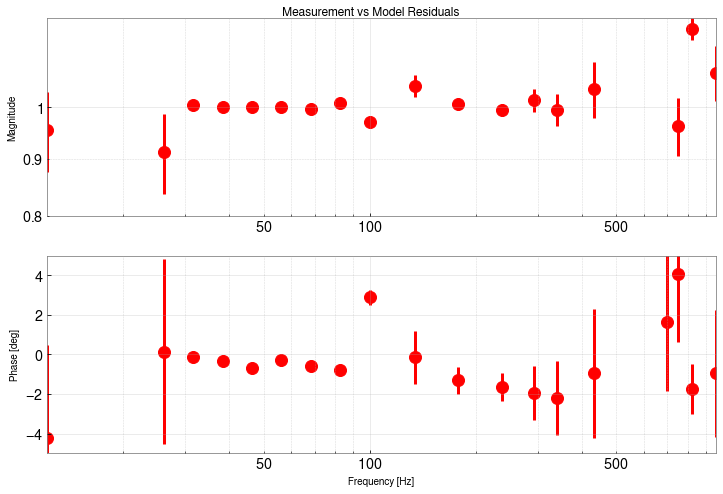

In [89]:
freq, tf, unc = pum_meas.get_processed_measurement_response()
pum = MAP_pum[0] * np.ones(len(frequencies))

h = pydarm.plot.residuals(frequencies, pum, freq, tf, unc, show=True)

Lastly, the UIM:

In [90]:
meas_obj_L1_exc = pydarm.measurement.Measurement(
    '/home/cal/svncommon/aligocalibration/trunk/Runs/O3/H1/Measurements/FullIFOActuationTFs/2021-04-16_H1SUSETMX_L1_iEXC2DARM_25min.xml')
meas_obj_L1_pcal = pydarm.measurement.Measurement(
    '/home/cal/svncommon/aligocalibration/trunk/Runs/O3/H1/Measurements/FullIFOActuationTFs/2021-04-16_H1SUSETMX_L1_PCAL2DARM_8min.xml')
uim_meas = pydarm.measurement.ProcessActuationMeasurement(model_string, 'actuation_x_arm', meas_obj_L1_exc, meas_obj_L1_pcal,
                                                    ('H1:SUS-ETMX_L1_CAL_EXC', 'H1:LSC-DARM_IN1_DQ'),
                                                    ('H1:CAL-PCALY_RX_PD_OUT_DQ', 'H1:LSC-DARM_IN1_DQ'),
                                                    meas1_cohThresh=0.9, meas2_cohThresh=0.9)
chain = uim_meas.run_mcmc(fmin=30, fmax=100, burn_in_steps=100, steps=100)
MAP_uim = np.median(chain, axis=0)
print(MAP_uim)

100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


[8.08016342 8.05449835]
[  1.62197458 -26.2100797 ]


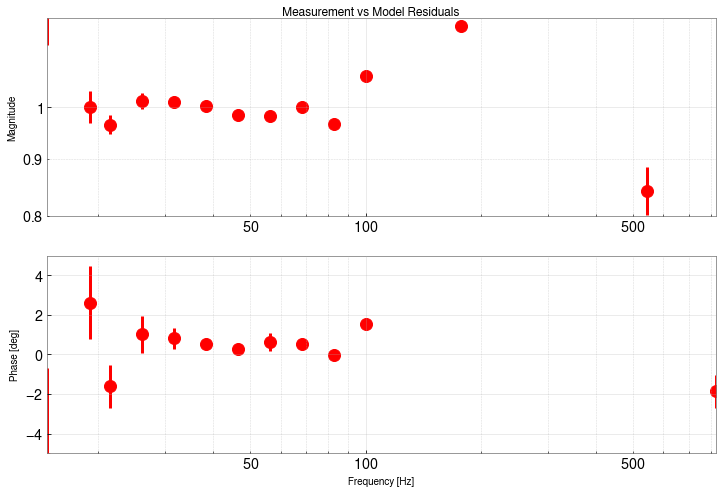

In [91]:
freq, tf, unc = uim_meas.get_processed_measurement_response()
uim = MAP_uim[0] * np.ones(len(frequencies))

h = pydarm.plot.residuals(frequencies, uim, freq, tf, unc, show=True)

Now we bring the updated values into a new model string and put it into the main DARM model

In [92]:
darm.actuation.xarm.uim_npa = MAP_uim[0]
darm.actuation.xarm.pum_npa = MAP_pum[0]
darm.actuation.xarm.tst_npv2 = MAP_tst[0]

### Characterization of systematic error (Gaussian Process Regression)

We utilize Gaussian Process Regression (GPR) to characterize the systematic error of the sensing and actuation functions.

/home/ethan.payne/.conda/envs/pydarm_dev/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/ethan.payne/.conda/envs/pydarm_dev/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1.5. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/ethan.payne/.conda/envs/pydarm_dev/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 0.9. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


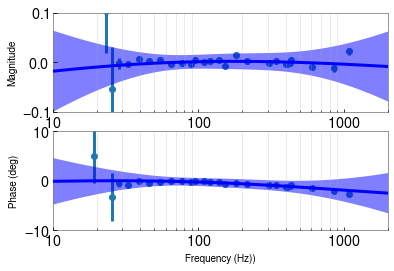

In [93]:
meas_obj_1 = pydarm.measurement.Measurement(
    '/home/cal/svncommon/aligocalibration/trunk/Runs/O3/H1/Measurements/FullIFOSensingTFs/2021-04-17_H1_DARM_OLGTF_LF_SS_5to1100Hz_15min.xml')
meas_obj_2 = pydarm.measurement.Measurement(
    '/home/cal/svncommon/aligocalibration/trunk/Runs/O3/H1/Measurements/FullIFOSensingTFs/2021-04-17_H1_PCAL2DARMTF_LF_SS_5t1100Hz_10min.xml')
meas = pydarm.measurement.ProcessSensingMeasurement(model_string, meas_obj_1, meas_obj_2,
                                                    ('H1:LSC-DARM1_IN2', 'H1:LSC-DARM1_EXC'),
                                                    ('H1:CAL-PCALY_RX_PD_OUT_DQ', 'H1:LSC-DARM_IN1_DQ'),
                                                    meas1_cohThresh=0.9, meas2_cohThresh=0.9,
                                                    json_results_file='./example_sensing.json')

gpr_out = meas.run_gpr(frequencies, [meas], 30, 5000, [30], [5000])
stacked_meas = meas.stack_measurements([meas], 30, 5000, [30], [5000])
ref_model = darm.sensing.coupled_cavity_optical_gain * signal.freqresp(pydarm.sensing.SensingModel.optical_response(darm.sensing.coupled_cavity_pole_frequency, darm.sensing.detuned_spring_frequency, darm.sensing.detuned_spring_q, darm.sensing.is_pro_spring), 2*np.pi*stacked_meas[0][0])[1]

plt.figure()
plt.subplot(211)
plt.errorbar(stacked_meas[0][0], abs(stacked_meas[0][1]/ref_model)-1, yerr=stacked_meas[0][2], fmt='.', label='Data', zorder=1)
plt.plot(frequencies, abs(gpr_out[0])-1, 'b-', label='Prediction', zorder=3)
plt.fill_between(frequencies, abs(gpr_out[0])-1 - gpr_out[1][:,0], y2=abs(gpr_out[0])-1 + gpr_out[1][:,1], alpha=.5, fc='b', ec='None', label='68% confidence', zorder=2)
plt.xscale('log')
plt.xlim(10,2000)
plt.ylim(-0.1, 0.1)
plt.ylabel('Magnitude')
plt.grid(which='both')
plt.subplot(212)
plt.errorbar(stacked_meas[0][0], np.angle(stacked_meas[0][1]/ref_model, deg=True), yerr=stacked_meas[0][2]*180/np.pi, fmt='.', label='Data', zorder=1)
plt.plot(frequencies, np.angle(gpr_out[0], deg=True), 'b-', zorder=3)
plt.fill_between(frequencies, np.angle(gpr_out[0], deg=True) - gpr_out[1][:,0]*180/np.pi, y2=np.angle(gpr_out[0], deg=True) + gpr_out[1][:,1]*180/np.pi, alpha=.5, fc='b', ec='None', label='68% confidence', zorder=2)
plt.xscale('log')
plt.xlabel('Frequency (Hz))')
plt.ylabel('Phase (deg)')
plt.xlim(10,2000)
plt.ylim(-10, 10)
plt.grid(which='both')
plt.show()

### Estimated uncertainty

The _h(t)_ uncertainty is estimated from several inputs:
1. reference model
1. MCMC measurements of model parameters (sensing and actuation)
1. time-dependent correction factors (TDCFs) as measured by the calibration lines
1. residual systematic error measured by the stacked measurements
1. systematic error in the photon calibrator

We build a configuration file to bring in these different pieces into an overall _h(t)_ uncertainty estimate

In [49]:
unc_config = '''
[sensing-measurement]
mcmc = 
gpr = 
[x-arm-measurement]
tst_mcmc = 
pum_mcmc = 
uim_mcmc = 
tst_gpr = 
pum_gpr = 
uim_gpr = 
[x-arm-sus-cal-lines]
uim = 15.6
pum = 16.4
tst = 17.6
[y-arm-pcal-cal-lines]
sus = 17.1
sensing = 410.3
pcal3 = 1083.7
pcal4 = 7.93
[tdcf-data]
frametype = R
duration = 130
[sensing-tdcf]
kappa_c = CAL-CS_TDEP_KAPPA_C_OUTPUT
f_cc = CAL-CS_TDEP_F_C_OUTPUT
pcal2_unc = CAL-CS_TDEP_PCAL_LINE2_UNCERTAINTY
pcal_arm = Y
[x-arm-tdcf]
kappa_uim = CAL-CS_TDEP_KAPPA_UIM_REAL_OUTPUT
kappa_pum = CAL-CS_TDEP_KAPPA_PUM_REAL_OUTPUT
kappa_tst = CAL-CS_TDEP_KAPPA_TST_REAL_OUTPUT
pcal1_unc = CAL-CS_TDEP_PCAL_LINE1_UNCERTAINTY
uim_unc = CAL-CS_TDEP_SUS_LINE1_UNCERTAINTY
pum_unc = CAL-CS_TDEP_SUS_LINE2_UNCERTAINTY
tst_unc = CAL-CS_TDEP_SUS_LINE3_UNCERTAINTY
pcal_arm = Y
[sample-tdcf]
kappa_c = False
f_cc = False
kappa_uim = False
kappa_pum = False
kappa_tst = False
[hoft-tdcf-data-application]
kappa_c = True
f_cc = True
kappa_uim = True
kappa_pum = True
kappa_tst = True
pcal_sys_err = False
[pcal]
sys_err =
sys_unc = 0.005
sample = True'''

In [52]:
test_unc = pydarm.uncertainty.DARMUncertainty(model_string, uncertainty_config=unc_config)
samples = test_unc.compute_response_uncertainty(1239958818, frequencies, trials=1)

/home/ethan.payne/.conda/envs/pydarm_dev/lib/python3.10/site-packages/gwpy/timeseries/core.py:1128: NDSWarning: no data received from nds.ldas.cit for [1239958753 ... 1239958883)
  warnings.warn(error.split('\n', 1)[0],
/home/ethan.payne/.conda/envs/pydarm_dev/lib/python3.10/site-packages/gwpy/timeseries/core.py:1128: NDSWarning: no data received from nds.ligo.caltech.edu for [1239958753 ... 1239958883)
  warnings.warn(error.split('\n', 1)[0],


### EPICS records

EPICS records are computed from the reference model file and the calibration line frequencies. Once computed, the values could be inserted into the respective records

In [53]:
epics = darm.compute_epics_records(f_pcal1=17.1, f_uim=15.6, f_pum=16.4, f_tst=17.6, f_pcal2=410.3, f_pcal3=1083.7, f_pcal4=7.93, arm='x')
print(epics)

{'CAL-CS_TDEP_PCAL_LINE1_CORRECTION': (0.003384106838174379+0.00040441800290648135j), 'CAL-CS_TDEP_SUS_LINE3_REF_INVA_TST_RESPRATIO': (1151641030091332.8-3658914281442102j), 'CAL-CS_TDEP_SUS_LINE2_REF_INVA_PUM_RESPRATIO': (-4.7897769809411706e+17-1.924398799071574e+17j), 'CAL-CS_TDEP_SUS_LINE1_REF_INVA_UIM_RESPRATIO': (2.614560297133459e+17-1.2582742342070266e+17j), 'CAL-CS_TDEP_PCAL_LINE2_REF_C_NOCAVPOLE': (3292403.9318186827-1006273.4304850588j), 'CAL-CS_TDEP_PCAL_LINE2_REF_D': (-243010006.42707008-1207741923.3996522j), 'CAL-CS_TDEP_PCAL_LINE2_REF_A_TST': (-3.827913185418979e-19+5.454360966753986e-19j), 'CAL-CS_TDEP_PCAL_LINE2_REF_A_PUM': (-3.609343283985194e-21+2.954620334252076e-21j), 'CAL-CS_TDEP_PCAL_LINE2_REF_A_UIM': (-1.964693133736417e-23-9.387912496521082e-23j), 'CAL-CS_TDEP_PCAL_LINE2_CORRECTION': (5.919275925544522e-06+3.3175673166307677e-07j), 'CAL-CS_TDEP_PCAL_LINE4_REF_C_NOCAVPOLE': (3439424.262240944-19694.64822656234j), 'CAL-CS_TDEP_PCAL_LINE4_REF_D': (-1334010103.6310

### Front end calibration correction

Filters are installed in the front end CAL-CS model to mimic an inverse sensing function and an actuation function. The front end, however, cannot produce an equivalent advance on the sensing side, so, instead, additional delay is added to the actuation path (in addition to extra delay needed on the actuation path):

Sensing 118.20640814156393 usec; or 2.0 integer number of 16384 cycles
Actuation 280.0826074344171 usec; or 5.0 integer number of 16384 cycles


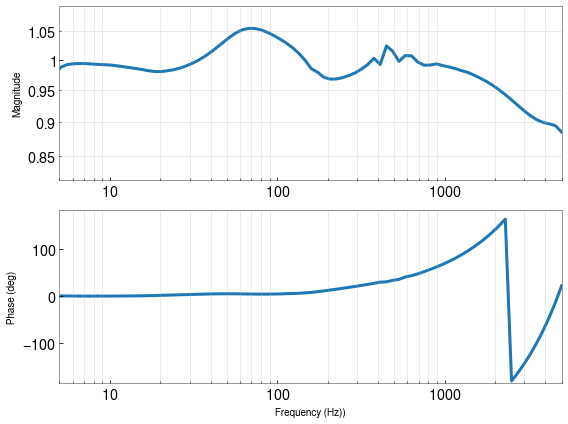

In [69]:
os.environ['CAL_DATA_ROOT'] = '../test/'
model_file = '../example_model_files/H1_20190416.ini'

calcs = pydarm.calcs.CALCSModel(model_file)

delay, resid = calcs.residual_sensing_sim_delay(frequencies)
clocks, resid2 = calcs.residual_sensing_sim_delay(frequencies, clock=True)
print(f'Sensing {delay/1e-6} usec; or {clocks} integer number of 16384 cycles')

frequencies_limited = np.logspace(np.log10(20), np.log10(100), 10)
delay, resid = calcs.residual_actuation_sim_delay(frequencies_limited)
clocks, resid2 = calcs.residual_actuation_sim_delay(frequencies_limited, clock=True)
print(f'Actuation {delay/1e-6} usec; or {clocks} integer number of 16384 cycles')

calcs_dtt_calib = calcs.calcs_dtt_calibration(frequencies)
calcs_dtt_calib_nowhit = calcs.calcs_dtt_calibration(frequencies, include_whitening=False)

plt.figure(figsize=[8,6])
plt.subplot(211)
plt.plot(frequencies, np.abs(calcs_dtt_calib_nowhit))
plt.xscale('log')
plt.yscale('log')
plt.xlim(5,5000)
plt.ylabel('Magnitude')
plt.grid(which='both')
plt.subplot(212)
plt.plot(frequencies, np.angle(calcs_dtt_calib_nowhit, deg=True))
plt.xscale('log')
plt.xlim(5,5000)
plt.ylim(-185,185)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (deg)')
plt.grid(which='both')
plt.tight_layout()

# Summary

We've shown that several main steps of the calibration procedure is able to be carried out by the new version of `pyDARM`, though with much still in development.
1. Model can be constructed from parameter configuration files or strings
1. DTT transfer function measurements can be processed through MCMC analysis
1. EPICS records for front end / control room calibration
1. Transfer functions for GDS / DCS pipelines are available as methods from `DARMModel` objects

## Remarks

This version of `pyDARM` (v2.0?) is being developed as a replacement for the O3 version of `pyDARM`. We are trying to make the code flexible, broadly usable, and robust. 
- Code can be developed in forks of the main repository; merge requests to bring those changes into the production version. 
- We use `flake8` to aid written code to conform to pep8 standards. 
- Unit tests validate and confirm that code changes do not break functionality (this has been a persistent problem since O1). 
- Code is meant to be "self-documenting" meaning that class methods need comment strings that explain how they work.